In [1]:
import sys
import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline

# parent directory to work with dev
sys.path.insert(0, '..')
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_card_toolkit.utils.tally_form import tally_form_to_mc
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)

In [2]:
# Credit card fraud Dataset
df = pd.read_csv("../data/fraud.csv")
x = df.drop("is_fraud", axis=1)
y = df["is_fraud"]


# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=4, max_features="sqrt", random_state = 882))])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)

## Get confusion matrix and ROC curve on train/test set

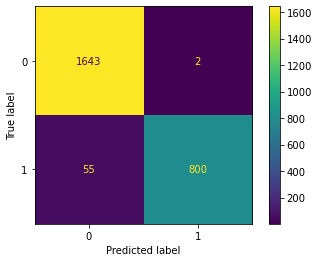

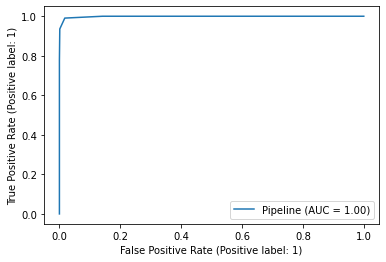

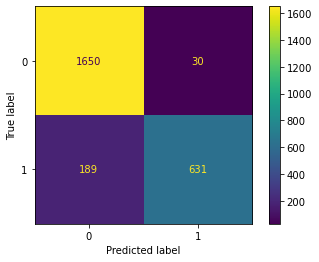

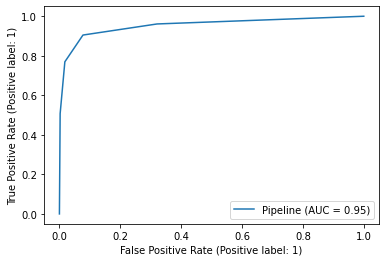

In [3]:
# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()

RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()

RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

## Run some FEAT Tests on the data

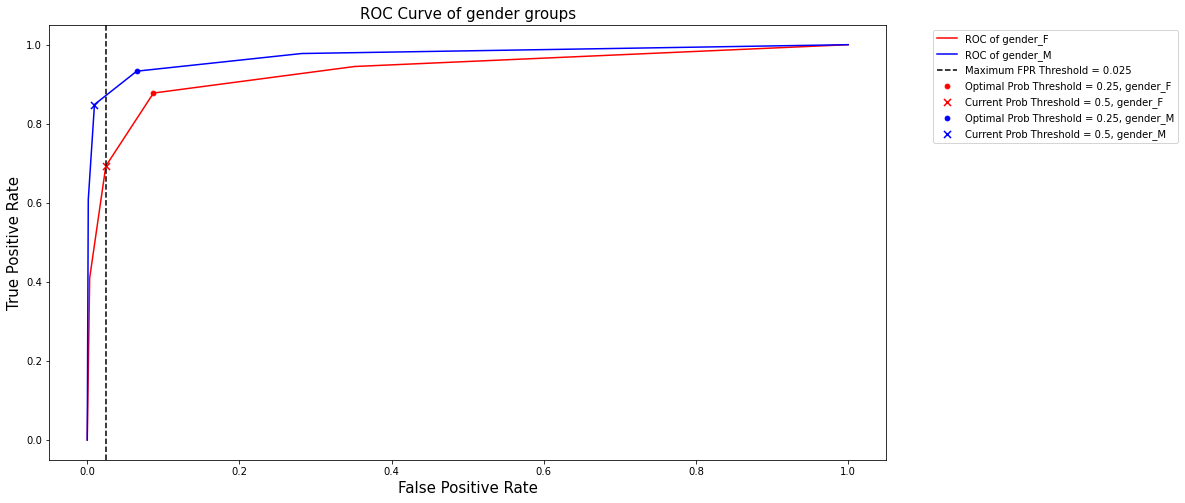

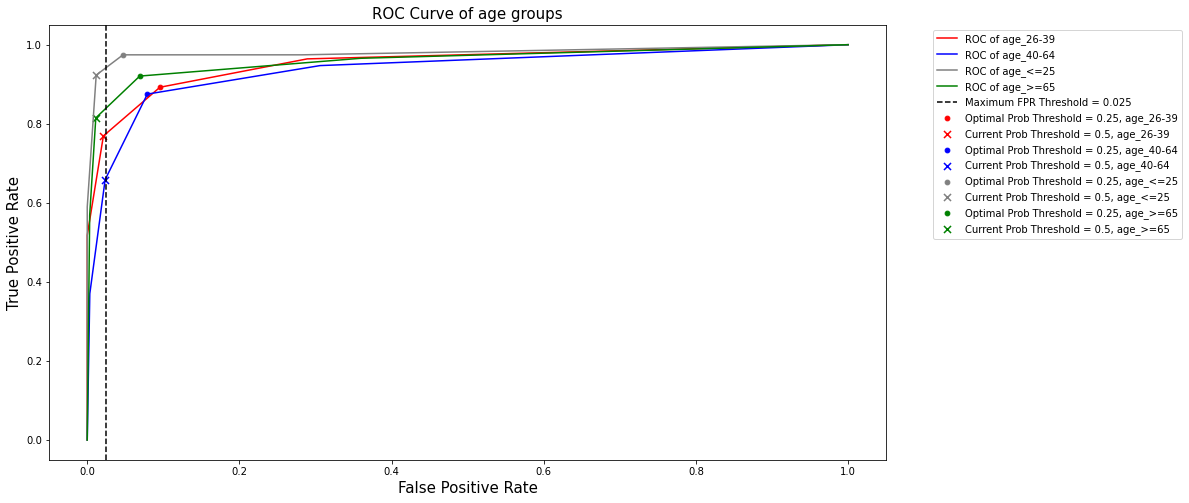

In [4]:
# ROC/Min Max Threshold Test

smt_test = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if not specified
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.025,
    #proba_threshold = 0.6 # Outcome probability threshold, default at 0.5
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

smt_test2 = MinMaxMetricThreshold(
    attr="age",
    metric="fpr",
    threshold=0.025,
)
smt_test2.run(df_test_with_output=output)
smt_test2.plot()

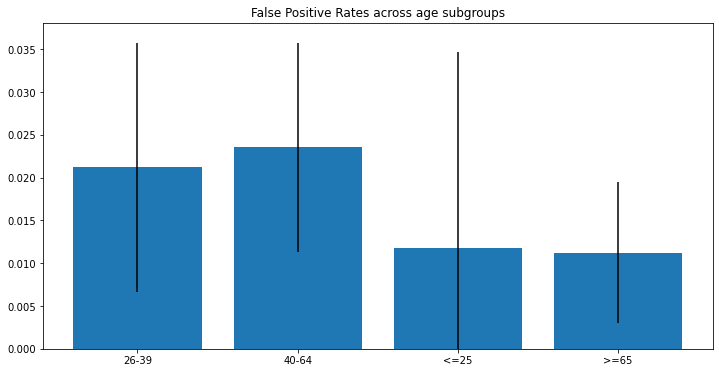

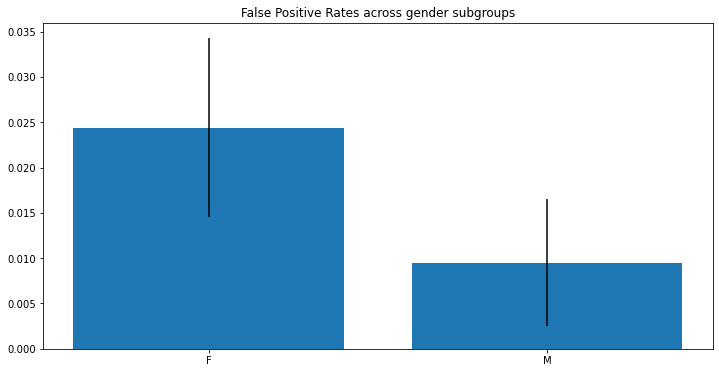

In [5]:
# Subgroup Disparity Test

sgd_test = SubgroupDisparity(
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test.run(output)
sgd_test.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test2 = SubgroupDisparity(
    attr='gender',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test2.run(output)
sgd_test2.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

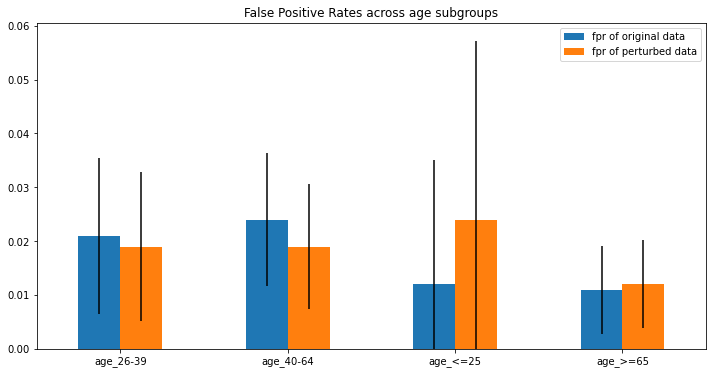

In [6]:
# Subgroup Perturbation Test

np.random.seed(123)
pmt = Perturbation(
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.5,
    #proba_threshold=0.6,  # Outcome probability threshold, default at 0.5
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=estimator[0],
    model=estimator[-1]
)

pmt.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

In [7]:
pmt.result

,fpr of original data,fpr of perturbed data,ratio,passed
age_26-39,0.021,0.019,1.140,True
age_40-64,0.024,0.019,1.268,True
age_<=25,0.012,0.024,0.482,True
age_>=65,0.011,0.012,0.959,True


model_output = "margin" has been renamed to model_output = "raw"


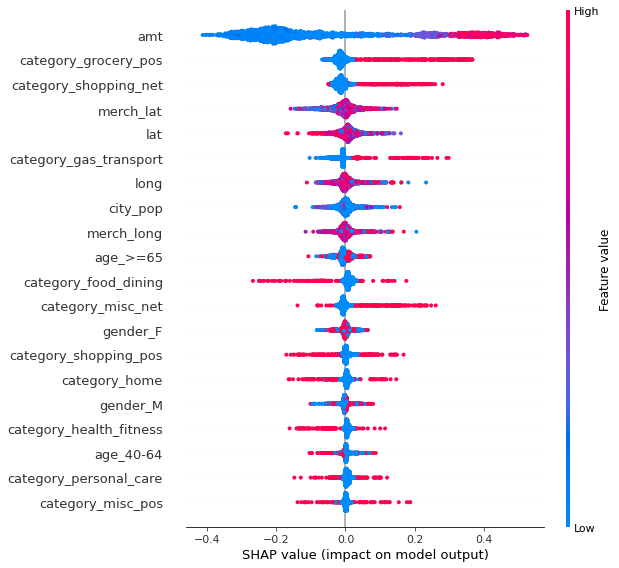

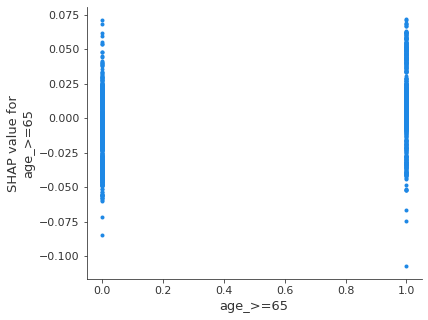

In [8]:
# Shapely Importance Features Test

shap_test = SHAPFeatureImportance(
    attrs=['gender','age'],
    threshold=10
)

shap_test.run(
    model=estimator[-1],
    model_type='trees',
    x_train_encoded=x_train_encoded,
    x_test_encoded=x_test_encoded,
)
shap_test.shap_summary_plot(x_test_encoded)
shap_test.shap_dependence_plot(x_test_encoded, show_all=False) # Show only dependence plots of attributes that failed the test

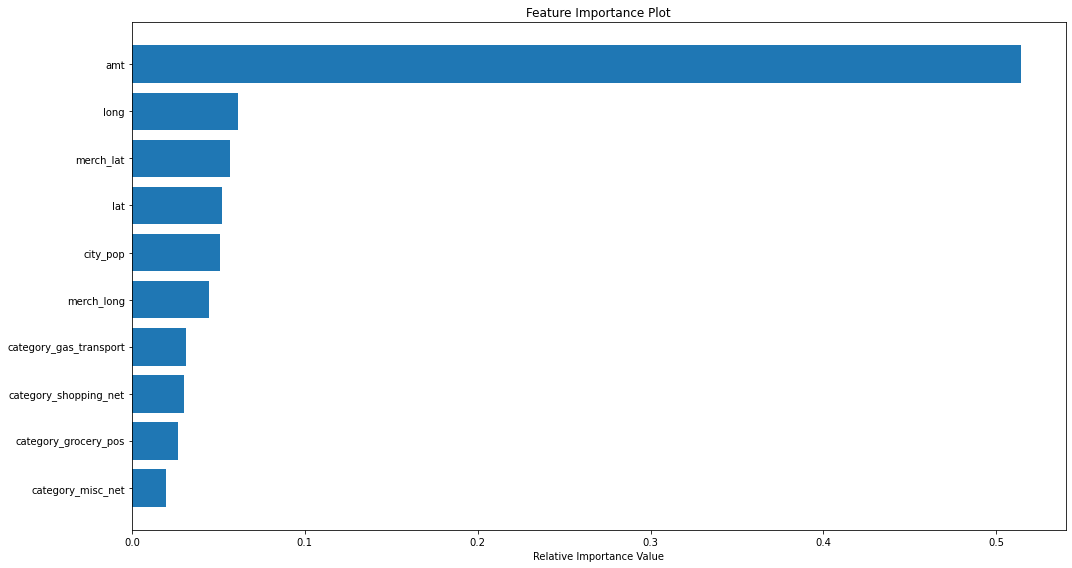

In [9]:
# User inputted Feature importance test

imp_test = FeatureImportance(
    attrs=['gender','age'],
    threshold=10
)

imp_test.run(df_importance)
imp_test.plot(df_importance, show_n=10)   # Show top 10 most important features

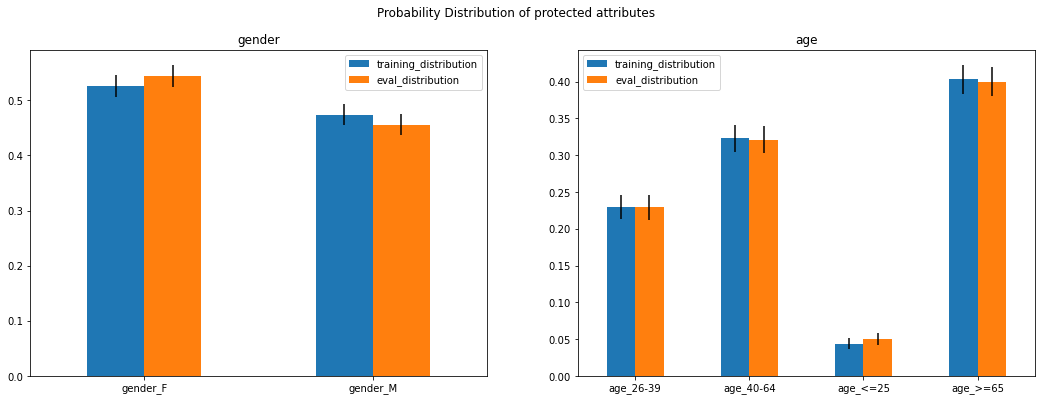

In [10]:
# Data distribution Shift Test

shift_test = DataShift(
    protected_attr = ['gender','age'],
    method = 'chi2',
    threshold = 0.05
)

shift_test.run(x_train = x_train, x_test = x_test)
shift_test.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response. This is meant only as an example - the dataset and risk evaluation in the model card is a fictional use case.

In [11]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response.json")

# Initialize the mct and scaffold using the existing protobuf
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="credit_card_fraud_example")
mc = mct.scaffold_assets(proto=pb)

## Convert test objects to a model-card-compatible format

In [12]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_smt_test2 = mctlib.Test()
mc_sgd_test = mctlib.Test()
mc_sgd_test2 = mctlib.Test()
mc_pmt_test = mctlib.Test()
mc_shap_test = mctlib.Test()
mc_imp_test = mctlib.Test()
mc_shift_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_smt_test2.read_model_test(smt_test2)
mc_sgd_test.read_model_test(sgd_test)
mc_sgd_test2.read_model_test(sgd_test2)
mc_pmt_test.read_model_test(pmt)
mc_imp_test.read_model_test(imp_test)
mc_shap_test.read_model_test(shap_test)
mc_shift_test.read_model_test(shift_test)

In [13]:
# Add quantitative analysis

# Create 4 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 4)]
mc.quantitative_analysis.performance_metrics[0].type = "Recall"
mc.quantitative_analysis.performance_metrics[0].value = str(recall_train)
mc.quantitative_analysis.performance_metrics[0].slice = "Training Set"

mc.quantitative_analysis.performance_metrics[1].type = "Precision"
mc.quantitative_analysis.performance_metrics[1].value = str(precision_train)
mc.quantitative_analysis.performance_metrics[1].slice = "Training Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_train), mctlib.Graphic(image=roc_curve_train)
]

mc.quantitative_analysis.performance_metrics[2].type = "Recall"
mc.quantitative_analysis.performance_metrics[2].value = str(recall_test)
mc.quantitative_analysis.performance_metrics[2].slice = "Test Set"

mc.quantitative_analysis.performance_metrics[3].type = "Precision"
mc.quantitative_analysis.performance_metrics[3].value = str(precision_test)
mc.quantitative_analysis.performance_metrics[3].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[3].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[3].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_test), mctlib.Graphic(image=roc_curve_test)
]


In [14]:
# You can add the components of a test (e.g. on explainability) in a report
mc.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Top 10 most important features", graphics=mctlib.GraphicsCollection(
            collection = [mctlib.Graphic(name=n, image=i) for n, i in imp_test.plots.items()]
        )
    )
]

# Or you can add it as a test directly
mc.explainability_analysis.explainability_reports.append(
    mctlib.ExplainabilityReport(type="Protected Attributes should not be model's top important features", tests=[mc_shap_test])
)

In [15]:
# The bootstrap template comes with two requirements on fairness analysis:
# Minimum acceptable service and Equal false positive rate
# We add the relevant tests associated with it
mc.fairness_analysis.fairness_reports[0].tests = [mc_smt_test,mc_smt_test2]
mc.fairness_analysis.fairness_reports[1].tests = [mc_sgd_test,mc_sgd_test2]

# We also add a test for attribute shift between the training and testing dataset for additional reliablity check
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type="Distribution of attribute subgroups should be silimiar across different datasets", tests=[mc_shift_test])
)
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type='Fairness metric for subgroups in original data and perturbed data should be similar', tests=[mc_pmt_test])
)

mct.update_model_card(mc)

## Model Card Display

In [16]:
# Export to html
html = mct.export_format(output_file="credit_card_fraud_example.html")
display.display(display.HTML(html))

,feature_rank,passed
age_>=65,10.0,False
gender_F,13.0,True
gender_M,16.0,True
age_40-64,18.0,True
age_26-39,21.0,True
age_<=25,26.0,True
,fpr at current probability threshold,passed
gender_F,0.024,True
gender_M,0.009,True


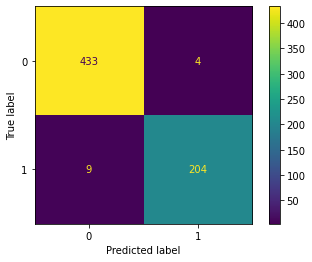

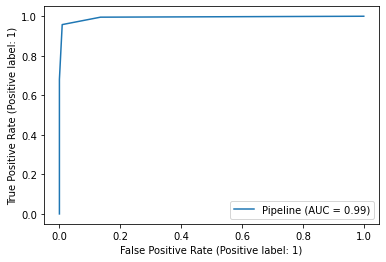

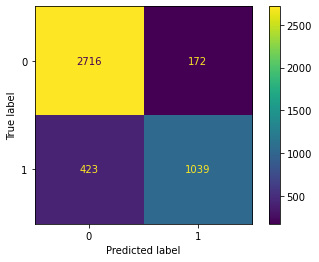

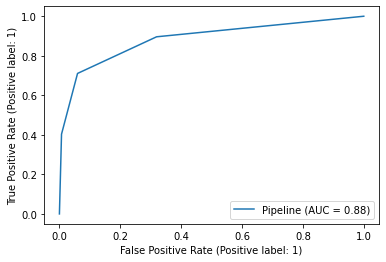

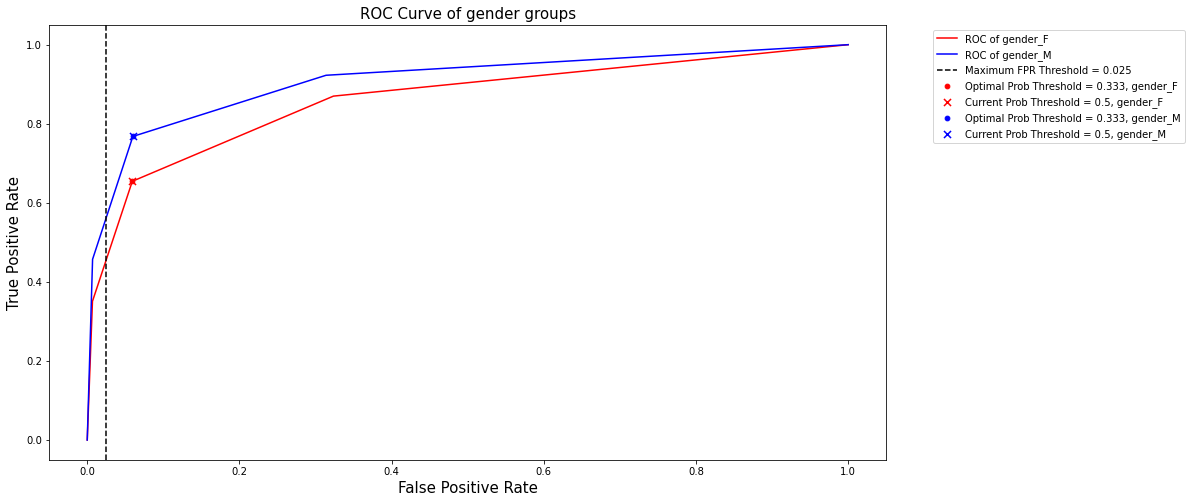

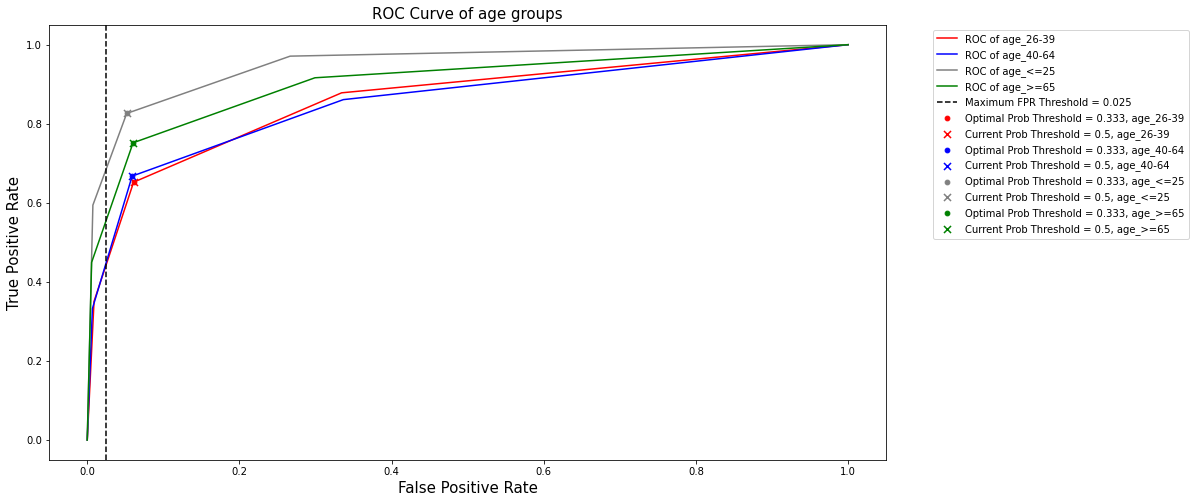

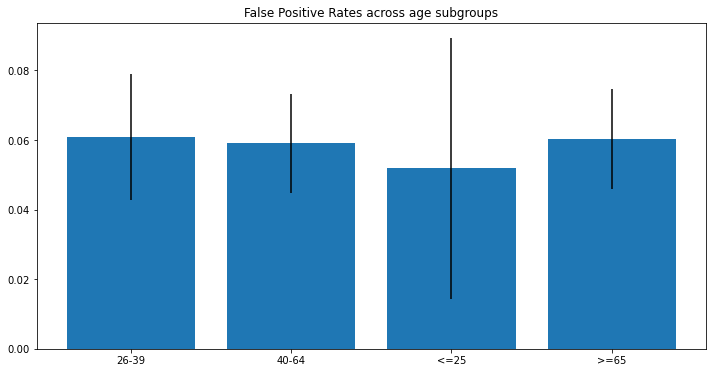

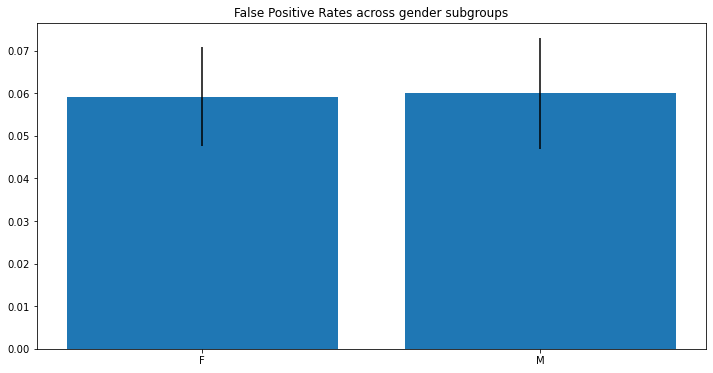

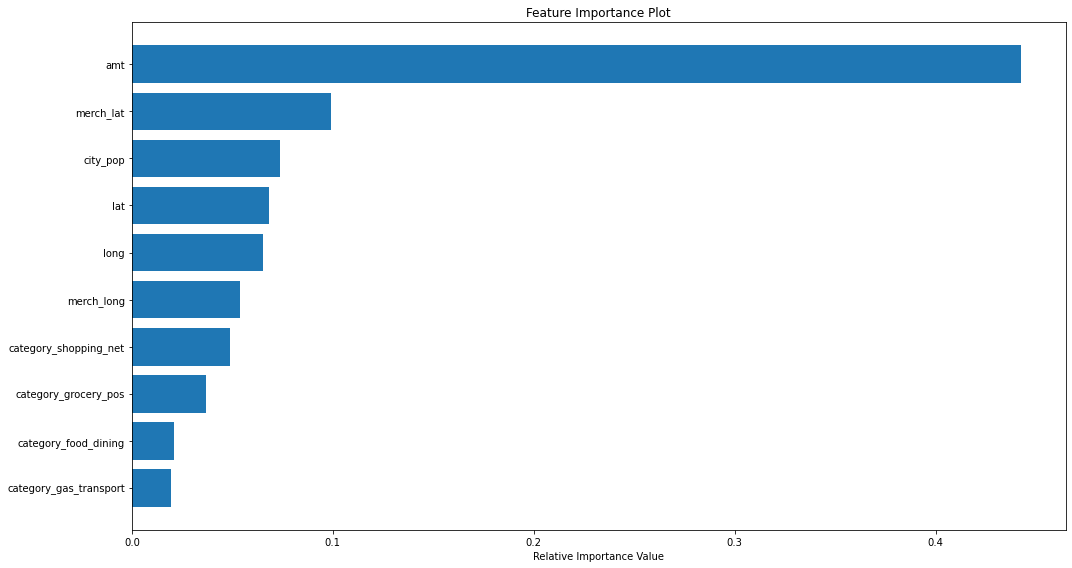

In [17]:
# Import model scorecard of second model (without protected attribute as model feature) from external python file
# Same steps taken as the first model, excluding irrelevant tests

# Model card to be compared with that of first model
from model_without_protected_attributes import mc2, mct2

In [18]:
# Export to html
html2 = mct2.export_format(output_file="credit_card_fraud_example2.html")
display.display(display.HTML(html2))

,fpr at current probability threshold,passed
gender_F,0.059,False
gender_M,0.06,False
,fpr at current probability threshold,passed
age_26-39,0.061,False
age_40-64,0.059,False
age_<=25,0.052,False
age_>=65,0.06,False


## Comparision between 2 model cards

In [19]:
# Compare the score cards (on the same content) between model1 and model2
html_compare=mct.compare_model_cards(mc, mc2, export_path='model_card_output/model_cards/credit_card_fraud_comparision.html')
display.display(display.HTML(html_compare))

,fpr at current probability threshold,passed
gender_F,0.024,True
gender_M,0.009,True
